<a href="https://colab.research.google.com/github/sanujsriv/_topic_models/blob/FoTo/FoTo_Keyword_Centered_DocModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# #@title
# !wget https://www.dropbox.com/s/9v5ar9xu2dv4e04/data_twentynews_preprocessed.pkl
!wget https://www.dropbox.com/s/09y9y1h0xk3cxaj/embeddings_twentynews.pkl
!wget https://www.dropbox.com/s/ewv3vcwgll0r8a7/data_twentynews_labels.pkl
!wget https://www.dropbox.com/s/chpjn9lzr7rmn2k/fixed_data_twentynews_preprocessed.pkl

In [ ]:
!wget https://www.dropbox.com/s/8khmuj31il8zgkp/data_reuters_labels.pkl
!wget https://www.dropbox.com/s/bgc1ht0jsyjed6s/embeddings_reuters.pkl
!wget https://www.dropbox.com/s/9fk30bjzeefvhgl/data_reuters_preprocessed.pkl

In [ ]:
#@title Imports
# from sympy.stats import RaisedCosine, density
import torch
import pandas as pd
from torch import nn
import re
from time import time
import numpy as np
import collections
import torch.optim as optim
# from utils import get_topwords, plot_fig
# from plsv_vae import PlsvVAE
# import data_preprocessing
from sklearn.feature_extraction.text import CountVectorizer
# from nltk.corpus import stopwords

In [ ]:
#@title function : load / save pickle_obj
import pickle

def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [ ]:
def load_reuters():
  embeddings = load_obj('embeddings_reuters')
  data_preprocessed = load_obj('data_reuters_preprocessed')
  data_preprocessed_labels = load_obj("data_reuters_labels")
  return data_preprocessed,data_preprocessed_labels,embeddings,load_reuters.__name__

In [ ]:
# ##### Data loading #####
loaded_data = load_reuters()
##########################
data_preprocessed , data_preprocessed_labels , embeddings, name = loaded_data
print(name,len(data_preprocessed_labels),len(data_preprocessed),len(embeddings))

load_reuters 7674 7674 13651


In [ ]:
preprossed_data = data_preprocessed
train_label = data_preprocessed_labels
vectorizer = CountVectorizer(min_df=10)
train_vec = vectorizer.fit_transform(preprossed_data).toarray()
vocab = vectorizer.vocabulary_
nonzeros_indexes = np.where(train_vec.any(1))[0]
train_vec_non_zeros = [train_vec[i] for i in nonzeros_indexes]
preprossed_data_non_zeros = [preprossed_data[i] for i in nonzeros_indexes]
train_label = [data_preprocessed_labels[i] for i in nonzeros_indexes]
# keywords = ['company', 'stock', 'pct']
keywords = ['oil','crude','ship']
train_vec = np.array(train_vec_non_zeros)

# all_rscores = cosine_similarity_desm_docs(keywords,train_vec,vocab, embeddings)
print(train_vec)
print(train_label)
print(vocab)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
['earn', 'acq', 'earn', 'earn', 'earn', 'earn', 'earn', 'earn', 'earn', 'earn', 'earn', 'earn', 'earn', 'earn', 'acq', 'trade', 'ship', 'earn', 'earn', 'earn', 'ship', 'earn', 'earn', 'earn', 'acq', 'earn', 'earn', 'earn', 'earn', 'earn', 'earn', 'earn', 'earn', 'earn', 'acq', 'earn', 'earn', 'acq', 'earn', 'earn', 'grain', 'acq', 'earn', 'crude', 'acq', 'earn', 'earn', 'acq', 'acq', 'grain', 'earn', 'earn', 'earn', 'earn', 'earn', 'crude', 'earn', 'earn', 'earn', 'earn', 'earn', 'acq', 'acq', 'earn', 'acq', 'earn', 'earn', 'earn', 'earn', 'earn', 'earn', 'earn', 'earn', 'acq', 'acq', 'earn', 'crude', 'crude', 'crude', 'earn', 'acq', 'earn', 'earn', 'earn', 'crude', 'earn', 'earn', 'interest', 'interest', 'crude', 'crude', 'crude', 'crude', 'money-fx', 'crude', 'money-fx', 'acq', 'trade', 'crude', 'earn', 'ship', 'acq', 'earn', 'acq', 'acq', 'acq', 'earn', 'interest',

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

tensor_train_w = torch.from_numpy(np.array(train_vec)).float()
train_label = np.asarray(train_label)

id_vocab = dict(map(reversed, vocab.items()))

num_coordinate = 2
bs = 256
en1_units_x = 100
en2_units_x = 100
num_input = train_vec[0].shape[0]
variance_x = 1
learning_rate = 0.002
beta1 = 0.99
beta2 = 0.999
drop_rate = 0.6
num_topic = 10

In [ ]:
we_matrix = []
for v in range(0, len(id_vocab)):
  we_matrix.append(embeddings[id_vocab[v]])
we_matrix = torch.from_numpy(np.array(we_matrix))

In [ ]:
qe_matrix = []
for v in range(0, len(keywords)):
  qe_matrix.append(embeddings[keywords[v]])
qe_matrix.append(np.zeros(300))
qe_matrix = torch.tensor(np.array(qe_matrix),dtype=torch.float32)

In [ ]:
# '# word2vec_model = []
import gc
gc.collect()

524

# Current Working Model

In [ ]:
#@title torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Parameter

In [ ]:
#@title Weight Drop
def _weight_drop(module, weights, dropout):
    """
    Helper for `WeightDrop`.
    """
    for name_w in weights:
        w = getattr(module, name_w)
        del module._parameters[name_w]
        module.register_parameter(name_w + '_raw', Parameter(w))

    original_module_forward = module.forward

    def forward(*args, **kwargs):
        for name_w in weights:
            raw_w = getattr(module, name_w + '_raw')
            w = torch.nn.functional.dropout(raw_w, p=dropout, training=module.training)

            setattr(module, name_w, w)

        # return original_module_forward(*args, **kwargs)

    setattr(module, 'forward', forward)


class WeightDrop(torch.nn.Module):
    """
    The weight-dropped module applies recurrent regularization through a DropConnect mask on the
    hidden-to-hidden recurrent weights.

    **Thank you** to Sales Force for their initial implementation of :class:`WeightDrop`. Here is
    their `License
    <https://github.com/salesforce/awd-lstm-lm/blob/master/LICENSE>`__.

    Args:
        module (:class:`torch.nn.Module`): Containing module.
        weights (:class:`list` of :class:`str`): Names of the module weight parameters to apply a
          dropout too.
        dropout (float): The probability a weight will be dropped.

    Example:

        >>> from torchnlp.nn import WeightDrop
        >>> import torch
        >>>
        >>> torch.manual_seed(123)
        <torch._C.Generator object ...
        >>>
        >>> gru = torch.nn.GRUCell(2, 2)
        >>> weights = ['weight_hh']
        >>> weight_drop_gru = WeightDrop(gru, weights, dropout=0.9)
        >>>
        >>> input_ = torch.randn(3, 2)
        >>> hidden_state = torch.randn(3, 2)
        >>> weight_drop_gru(input_, hidden_state)
        tensor(... grad_fn=<AddBackward0>)
    """

    def __init__(self, module, weights, dropout=0.0):
        super(WeightDrop, self).__init__()
        _weight_drop(module, weights, dropout)
        self.forward = module.forward

class WeightDropLinear(torch.nn.Linear):
    """
    Wrapper around :class:`torch.nn.Linear` that adds ``weight_dropout`` named argument.

    Args:
        weight_dropout (float): The probability a weight will be dropped.
    """

    def __init__(self, *args, weight_dropout=0.0, **kwargs):
        super().__init__(*args, **kwargs)

        weights = ['weight']
        # print('name_w in _weight_drop: ', name_w)
        _weight_drop(self, weights, weight_dropout)

In [ ]:
# @title Targeted Dropout Class
import torch
import torch.nn as nn


class TargetedDropout(nn.Module):
    """
    Learning Sparse Networks Using Targeted Dropout
    https://arxiv.org/abs/1905.13678
    """

    def __init__(self,targeted="weight",target_layer=None,
                 dropout_rate=0.5,targeted_portion=0.5):
        super(TargetedDropout, self).__init__()
        self.targeted = targeted
        self.target_layer = target_layer
        self.dropout_rate = dropout_rate
        self.targeted_portion = targeted_portion
        self.weight = target_layer.weight

        if self.targeted == "weight":
            self.targeted_dropout = targeted_weight_dropout
        elif self.targeted == "unit":
            self.targeted_dropout = targeted_unit_dropout

    def forward(self):
        self.weight = self.targeted_dropout(
            weight=self.target_layer.weight,
            dropout_rate=self.dropout_rate,
            targeted_portion=self.targeted_portion,
            is_training=self.training,
        )

        self.target_layer.weight = self.weight
        # output = self.target_layer(x)
        return self.weight

    def extra_repr(self):
        return f"targeted={self.targeted}, dropout_rate={self.dropout_rate}, targeted_portion={self.targeted_portion}"


def targeted_weight_dropout(weight, dropout_rate, targeted_portion, is_training):
    weight_shape = weight.shape
    weight = torch.reshape(weight, [-1, weight_shape[-1]]).float()

    norm = torch.abs(weight)
    idx = int(targeted_portion * torch.tensor(weight.shape[0]).float())
    threshold = torch.sort(norm, dim=0)[0][idx]
    mask = norm < threshold[None, :]

    if not is_training:
        mask = (torch.rand_like(weight) < dropout_rate).to(mask.device.type) & mask

    weight = (1.0 - mask.float()) * weight
    weight = torch.reshape(weight, weight_shape)
    weight = torch.nn.Parameter(weight)

    return weight

def targeted_unit_dropout(weight, dropout_rate, targeted_portion, is_training):
    weight_shape = weight.shape
    weight = torch.reshape(weight, [-1, weight_shape[-1]]).float()

    norm = torch.norm(weight, dim=0)
    idx = int(targeted_portion * int(weight.shape[1]))
    sorted_norms = torch.sort(norm)[0]
    threshold = sorted_norms[idx]
    mask = (norm < threshold)[None, :]
    mask = mask.repeat(weight.shape[0], 1)

    if not is_training:
        mask = torch.where(
            ((1.0 - dropout_rate) < torch.rand_like(weight)).to(mask.device.type)
            & mask,
            torch.ones_like(weight, dtype=torch.float32),
            torch.zeros_like(weight, dtype=torch.float32),
        )

    weight = (1.0 - mask.float()) * weight
    weight = torch.reshape(weight, weight_shape)
    weight = torch.nn.Parameter(weight)

    return weight

In [ ]:
torch.cuda.empty_cache()

smoothen=1e-20
gaussian_variance=torch.tensor(0.5)
pi = 3.1415927410125732

def gaussian_dist(x,mu,variance=gaussian_variance):
  x_expand = x.unsqueeze(1).expand(x.shape[0],mu.shape[0],x.shape[1])
  exp_term = torch.exp( -0.5 * torch.sum(((x_expand-mu)/variance)**2,dim=-1) )
  var_term = 1.0 / (variance * ((2*pi)**0.5))
  ret = var_term * exp_term
  return ret

def NewBeta_dist(x,mu,phi_beta,smoothen):
  First = torch_lgamma(phi_beta+smoothen) - (torch_lgamma(phi_beta * mu+smoothen) + torch_lgamma(phi_beta * (1-mu)+smoothen ))
  Second_1 = (mu*phi_beta-1) * torch.log(x+smoothen)
  Second_2 = ( (1-mu)*phi_beta-1 )* torch.log(1-x+smoothen)
  Second = Second_1 + Second_2
  return First + Second

def LogL_NewBeta(x,relevant_scores):
  x_norm = torch.norm(x,dim=-1)
  mu = torch.exp(-0.5 * (torch.pow(x_norm,2))/mu_div)
  LogL = NewBeta_dist(relevant_scores,mu,sig,smoothen)
  return LogL.sum()


#phi
def gaussian(alpha): return -0.5*alpha
def inverse_multi_quadric(alpha): return -0.5*torch.log(torch.ones_like(alpha) + alpha)
def inverse_quadratic(alpha): return -torch.log(torch.ones_like(alpha) + alpha)

class Model(nn.Module):
    def __init__(self, num_input, en1_units_x, en2_units_x, num_coordinate, num_topic, drop_rate, variance_x, bs,num_keyword, distance="gaussian"):
        super(Model, self).__init__()
        self.num_input, self.num_coordinate, self.num_topic, self.variance_x, self.bs, self.num_keyword\
            = num_input, num_coordinate, num_topic, variance_x, bs,num_keyword

        # encoder
        self.en1_fc     = nn.Linear(num_input, en1_units_x)             # V -> 100 #nxV->(vxh1)->nxh1;
        self.en2_fc     = nn.Linear(en1_units_x, en2_units_x)             # 100  -> 100
        self.en2_drop   = nn.Dropout(drop_rate)
        self.mean_fc    = nn.Linear(en2_units_x, num_coordinate)        # 100  -> 2
        self.mean_bn    = nn.BatchNorm1d(num_coordinate)              # bn for mean
        self.logvar_fc  = nn.Linear(en2_units_x, num_coordinate)        # 100  -> 2
        self.logvar_bn  = nn.BatchNorm1d(num_coordinate)              # bn for logvar

        # RBF
        self.in_features = self.num_coordinate
        self.out_features = self.num_topic
        self.centres = nn.Parameter(torch.Tensor(self.out_features, self.in_features))

        self.query_words = nn.Parameter(torch.Tensor(self.num_keyword,self.in_features))

        if distance=="gaussian": self.basis_func = gaussian
        if distance=="inverse_quadratic": self.basis_func = inverse_quadratic
        if distance=="inverse_multi_quadric": self.basis_func = inverse_multi_quadric
        self.init_parameters()

        # decoder layer
        self.decoder    = nn.Linear(self.num_topic, self.num_input)             # 50   -> 1995
        self.decoder_bn = nn.BatchNorm1d(self.num_topic)                      # bn for decoder

        # decoder document
        self.decoder_phi_bn = nn.BatchNorm1d(num_coordinate)                      # bn for decoder
        self.decoder_x_bn = nn.BatchNorm1d(num_coordinate)
        self.decoder_q_bn = nn.BatchNorm1d(num_coordinate)

        # prior mean and variance as constant buffers
        prior_mean   = torch.Tensor(1, num_coordinate).fill_(0)
        prior_var    = torch.Tensor(1, num_coordinate).fill_(variance_x)
        self.prior_mean = nn.Parameter(prior_mean, requires_grad=False)
        self.prior_var  = nn.Parameter(prior_var, requires_grad=False)
        self.prior_logvar = nn.Parameter(prior_var.log(), requires_grad=False)


    def init_parameters(self):
        nn.init.normal_(self.centres, 0, 0.01)
        nn.init.normal_(self.query_words, 0, 0.01)

    def encode(self, input_):
        N, *_ = input_.size()
        en1 = F.softplus(self.en1_fc(input_))                           # en1_fc   output
        en2 = F.softplus(self.en2_fc(en1))                              # encoder2 output
        en2 = self.en2_drop(en2)
        posterior_mean   = self.mean_bn  (self.mean_fc  (en2))          # posterior mean
        posterior_logvar = self.logvar_bn(self.logvar_fc(en2))          # posterior log variance
        posterior_var    = posterior_logvar.exp()

        return en2, posterior_mean, posterior_logvar, posterior_var

    def take_sample(self, input_, posterior_mean, posterior_var, prior_var):
        eps = input_.data.new().resize_as_(posterior_mean.data).normal_(std=1) # noise
        z = posterior_mean + posterior_var.sqrt() * eps                   # reparameterization
        return z

    def decode(self, z):
        # decode

        N, *_ = z.size()
        zx = self.decoder_x_bn(z).view(N, 1, self.num_coordinate) # Nx1xX
        size = (N, self.out_features, self.in_features) # N,T,2
        x = zx.expand(size)
        c = self.decoder_phi_bn(self.centres).unsqueeze(0).expand(size)
        d = (x-c).pow(2).sum(-1)
        distances = self.basis_func(d) #NxK
        zx_phi = torch.exp(distances - torch.logsumexp(distances, dim=-1, keepdim=True))

        sizeq = (N, self.num_keyword, self.in_features) # N,Q,2
        xq = zx.expand(sizeq)
        cq = self.decoder_q_bn(self.query_words).unsqueeze(0).expand(sizeq)
        dq = (xq-cq).pow(2).sum(-1)
        distancesq = self.basis_func(dq) #NxK
        zx_q = torch.exp(distancesq - torch.logsumexp(distancesq, dim=-1, keepdim=True))

        recon_v = torch.mm(zx_phi, F.softmax(self.decoder_bn(self.decoder.weight).transpose(1,0), dim=-1))
        return recon_v, zx, zx_phi, d, c, zx_q

    def forward(self, input_, we_matrix,qe_matrix, compute_loss=False):
        en2, posterior_mean, posterior_logvar, posterior_var = self.encode(input_)
        z = self.take_sample(input_, posterior_mean, posterior_var, self.variance_x)

        # decode
        recon_v, zx, zx_phi,d,c,zx_q= self.decode(z)

        if compute_loss:
            return recon_v, self.loss(input_, recon_v, zx_phi, posterior_mean, posterior_logvar, posterior_var, d, c, we_matrix,qe_matrix, zx,zx_q)
        else:
            return z, recon_v, zx, zx_phi


    def loss(self, input_, recon_v, zx_phi, posterior_mean, posterior_logvar, posterior_var, d, c, we_matrix,qe_matrix, zx,zx_q, avg=True):
        N = posterior_mean.shape[0]
        L = recon_v.shape[0]
        NL = - (input_ * (recon_v+1e-20).log()).sum(-1)

        wq_density = gaussian_dist(we_matrix,qe_matrix) #VxQ
        recon_q = -(input_ * (torch.mm(zx_q,wq_density.transpose(1,0))+1e-20).log()).sum(-1)

        prior_mean   = self.prior_mean.expand_as(posterior_mean)
        prior_var    = self.prior_var.expand_as(posterior_mean)
        prior_logvar = self.prior_logvar.expand_as(posterior_mean)

        var_division    = posterior_var  / prior_var #Nx2
        diff            = posterior_mean - prior_mean
        diff_term       = diff * diff / prior_var
        logvar_division = prior_logvar - posterior_logvar

        xKLD = 0.5 * ( (var_division + diff_term + logvar_division).sum(-1) - self.num_coordinate)
        return_xKLD = xKLD.sum()
        KL = return_xKLD

        NL_sum = NL.sum()
        recon_q_sum = recon_q.sum()

        loss = NL_sum + KL + recon_q_sum

        # print(type(loss))
        return loss/N, NL_sum, return_xKLD,  KL, recon_q_sum

In [ ]:
model = Model(num_input, en1_units_x, en2_units_x, num_coordinate, num_topic, drop_rate, variance_x, bs,len(keywords)+1, "inverse_quadratic")
model.to(device)
optimizer = optim.Adam(model.parameters(), learning_rate, betas=(beta1, beta2))
epochs = 1000
phi_arr = []
beta_arr = []
x_arr = []
recon_arr = []
neg_log_rscore_arr=[]
list_d = []

all_indices = torch.randperm(tensor_train_w.size(0)).split(bs)

for epoch in range(epochs):
    loss_u_epoch = 0.0
    loss_xkl_epoch = 0.0
    loss_betakl_epoch = 0.0
    loss_phikl_epoch = 0.0
    loss_KLD = 0.0
    loss_phi_epoch = 0.0
    recon_ep = 0.0
    loss_epoch = 0.0
    neg_log_rscore_ep = 0.0
    model.train()
    d_temp = []
    count = 0

    for batch_ndx in all_indices:

        input_w = tensor_train_w[batch_ndx].to(device)
        labels = train_label[batch_ndx]
        we_matrix_d = we_matrix.to(device)
        qe_matrix_d = qe_matrix.to(device)
        recon_v, (loss, loss_u, xkl_loss, kl, neg_log_rscore) = model(input_w, we_matrix_d,qe_matrix_d, compute_loss=True)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()             # backpror.step()            # update parameters
        loss_epoch += loss.item()
        loss_u_epoch += loss_u.item()
        loss_xkl_epoch += xkl_loss.item()
        loss_KLD += kl.item() #/ len(tensor_train_w))
        recon_ep += recon_v.mean().item()
        neg_log_rscore_ep += neg_log_rscore.item()
        count = count + 1;
    x_arr.append(loss_xkl_epoch)
    recon_arr.append(loss_u_epoch)
    neg_log_rscore_arr.append(neg_log_rscore_ep)

    if epoch % 10 == 0:
        print('Epoch {}, loss={}'.format(epoch, loss_epoch))
        print('x_loss={}, recon_loss={}, KLD= {}, neg_loss = {}'.format(loss_xkl_epoch, loss_u_epoch, loss_KLD,neg_log_rscore_ep))

Epoch 0, loss=45132.26062011719
x_loss=12636.191375732422, recon_loss=3546814.3125, KLD= 12636.191375732422, neg_loss = 7985219.671875
Epoch 10, loss=41644.78137207031
x_loss=8852.269134521484, recon_loss=2971882.5703125, KLD= 8852.269134521484, neg_loss = 7671743.078125
Epoch 20, loss=41358.5029296875
x_loss=5590.722595214844, recon_loss=2958758.5859375, KLD= 5590.722595214844, neg_loss = 7614892.90625
Epoch 30, loss=41170.63220214844
x_loss=8118.444915771484, recon_loss=2921272.90625, KLD= 8118.444915771484, neg_loss = 7601792.875
Epoch 40, loss=41019.947509765625
x_loss=11565.6484375, recon_loss=2891203.4140625, KLD= 11565.6484375, neg_loss = 7589871.09375
Epoch 50, loss=40921.603759765625
x_loss=10916.141357421875, recon_loss=2877799.71875, KLD= 10916.141357421875, neg_loss = 7578767.28125
Epoch 60, loss=40851.55090332031
x_loss=11081.685028076172, recon_loss=2866413.3515625, KLD= 11081.685028076172, neg_loss = 7572069.078125
Epoch 70, loss=40777.903076171875
x_loss=11683.782714843

In [ ]:
# plot_loss(neg_log_rscore_arr,"neg")

In [ ]:
#  torch.save(model.state_dict(),'Foto_beta_t20_a100_div500_e20_20news_reuters.t7')

In [ ]:
# ## Loading a Saved Model
# model = PlsvVAE(num_input, en1_units_x, en2_units_x, num_coordinate, num_topic, drop_rate, variance_x, bs, "inverse_quadratic")
# model.to(device)
# all_indices = torch.randperm(tensor_train_w.size(0)).split(bs)
# model.load_state_dict(torch.load('Foto_beta_t50_a100_div500_e20_20news_reuters.t7'))

In [ ]:
def get_topwords(beta, id_vocab):
    topic_indx = 0
    topwords_topic = []
    for i in range(len(beta)):
        topwords_topic.append( str(topic_indx)+": "+ " ".join([id_vocab[j] for j in beta[i].argsort()[:-10 - 1:-1]]))
        topic_indx+=1
    return topwords_topic

In [ ]:
model.eval()
x_list = []
phi_list = []
beta_list = []
labels_list = []
doc_ids = []
zx_phi_list=[]

with torch.no_grad():
    for batch_ndx in all_indices:
        input_w = tensor_train_w[batch_ndx].to(device)
        labels = train_label[batch_ndx]
        we_matrix_d = we_matrix.to(device)
        qe_matrix_d = qe_matrix.to(device)
        labels_list.extend(labels)
        z, recon_v, zx, zx_phi = model(input_w, we_matrix_d,qe_matrix_d, compute_loss=False)
        zx = zx.view(-1, num_coordinate).data.detach().cpu().numpy()
        zx_phi = zx_phi.view(-1, num_topic).data.detach().cpu().numpy()
        zx_phi_list.extend(zx_phi)
        x_list.extend(zx)
        doc_ids.extend(batch_ndx)

    x_list = np.array(x_list)
    # zx_phi_list =  np.array(zx_phi_list)

    beta = model.decoder.weight.data.cpu().numpy().T#
    zphi = model.decoder_phi_bn(model.centres).data.cpu().numpy()
    query_words = model.decoder_q_bn(model.query_words).data.cpu().numpy()
    print("---"*10)
    topword_topics = get_topwords(beta, id_vocab)
    topword_topics_list=[]
    for topwords in topword_topics:
        topword_topics_list.append(topwords.split())
        print(topwords)
    print("---"*10)

------------------------------
0: said bank trade rate pct market billion year would japan
1: oil gas reserve ltd petroleum canada canadian fell fuel week
2: said dlrs mln company year sale inc corp first quarter
3: oil said price opec crude barrel bpd mln production would
4: year mln dlrs stock effective five unit sale pct co
5: mln ct net loss shr dlrs rev qtr profit year
6: mln dlr co period resource industry amount product three credit
7: said share company pct offer stock group would inc dlrs
8: mln ct billion dividend april record share net march stock
9: dlrs two year march may june billion april per share
------------------------------


In [ ]:
def get_Z(X,Y):
  norms = torch.zeros(X.shape)
  Z = torch.zeros(X.shape)

  for i in range(X.shape[0]):
    for j in range(X.shape[0]):
      v = torch.tensor([X[i][j],Y[i][j]])
      norms[i][j] = torch.norm(v)
      Z[i][j]=torch.exp(-0.5 * (torch.pow(norms[i][j],2))/mu_div)
  return Z

In [ ]:
def get_Contour(ax,x_list):
  xlist = np.linspace(-50, 50, 200)
  ylist = np.linspace(-50, 50, 200)
  X, Y = np.meshgrid(xlist, ylist)
  Z = get_Z(X,Y)
  levels = np.arange(0,1,0.1)
  cp = ax.contour(X, Y, Z, levels=levels)
  ax.clabel(cp, inline=1, fontsize=10)

In [ ]:
import collections
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, show
import seaborn as sb

def plot_fig(zx, labels_list, zphi,query_words):
    labels = []
    for i in range(len(labels_list)):
        labels.append('C'+str(labels_list[i]))
    fig, ax = plt.subplots( figsize=(20, 20))
    # get_Contour(ax,zx)

    sb.scatterplot(ax=ax,x=zx[:,0],y=zx[:,1],hue=labels_list,alpha=0.8,palette='deep')
    ax.set(ylim=(-50,50))
    ax.set(xlim=(-50,50))


    # ax.scatter(zx[:,0], zx[:,1], alpha=0.8, c=labels, facecolors='none', s=8)
    # for d in range(len(labels_list)):
    #  score = rounded_normalized_all_rscores[doc_ids[d]].item()
    #  if(score>0.7 and score<0.9):
    #   ax.text(zx[d,0],zx[d,1], str(round(score, 3) ) )

    # ax.text(query_center[0],query_center[1], 'X' ,c='black')
    for i in range(len(query_words)):
      if(i==len(query_words)-1):
        ax.text(query_words[i][0],query_words[i][1], 'X' ,c='black')
      else:
        ax.text(query_words[i][0],query_words[i][1], 'X'+keywords[i] ,c='black')
    ax.scatter(zphi[:, 0], zphi[:, 1], alpha=1.0,  edgecolors='black', facecolors='none', s=30)

    for indx, topic in enumerate(zphi):
        ax.text(zphi[indx, 0], zphi[indx, 1], 'topic'+str(indx))

In [ ]:
query_words

array([[ 9.28596  , -3.7990062],
       [ 3.7948809, -0.9637254],
       [ 1.3383917,  2.0104182],
       [47.367783 , -6.392568 ]], dtype=float32)

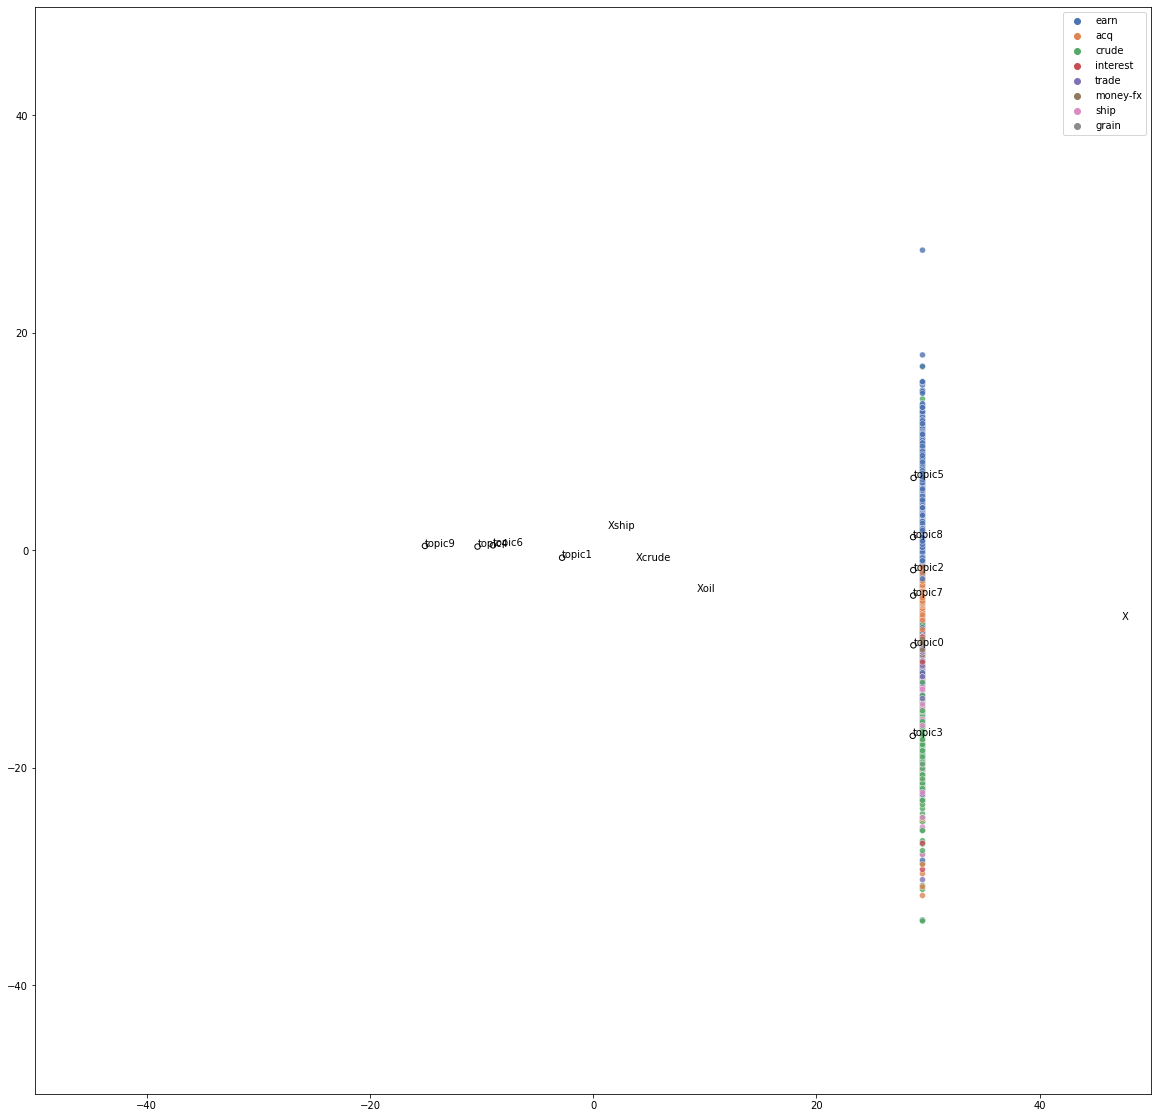

In [ ]:
plot_fig(x_list, labels_list, zphi,query_words)

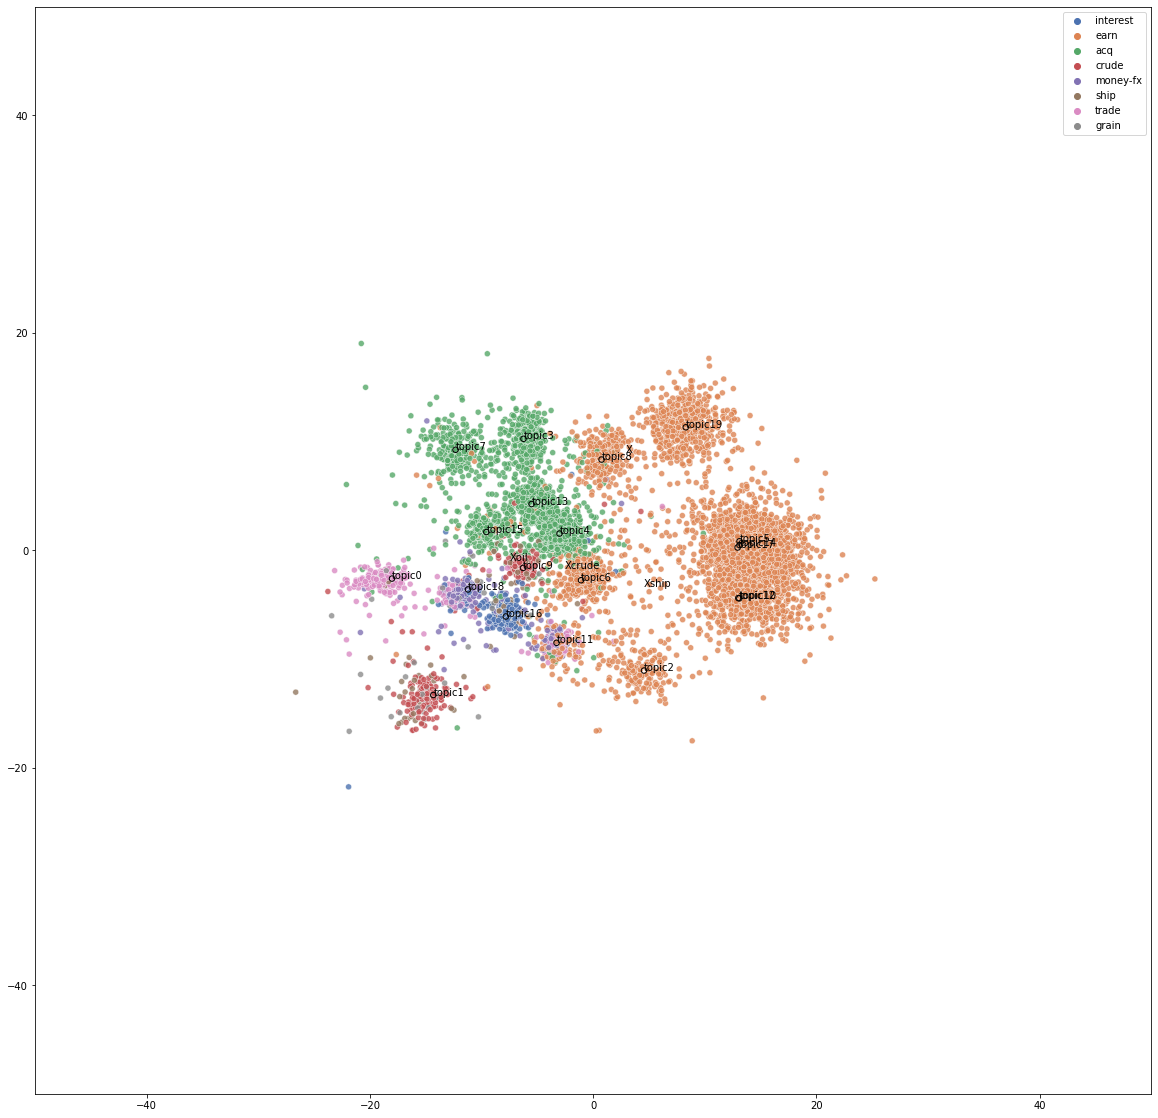

In [ ]:
plot_fig(x_list, labels_list, zphi,query_words)

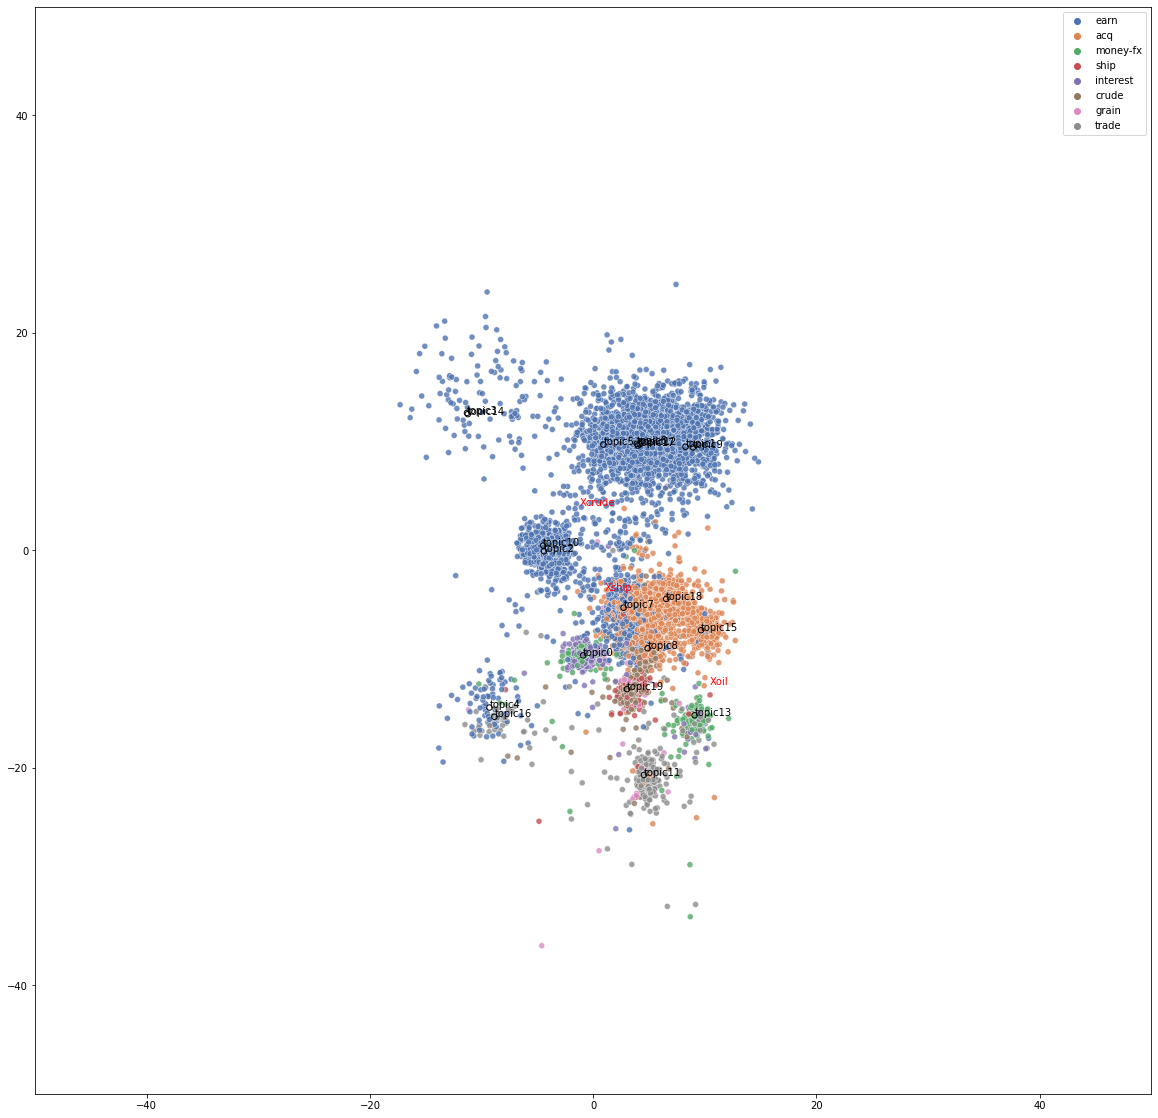

In [ ]:
plot_fig(x_list, labels_list, zphi,query_words)

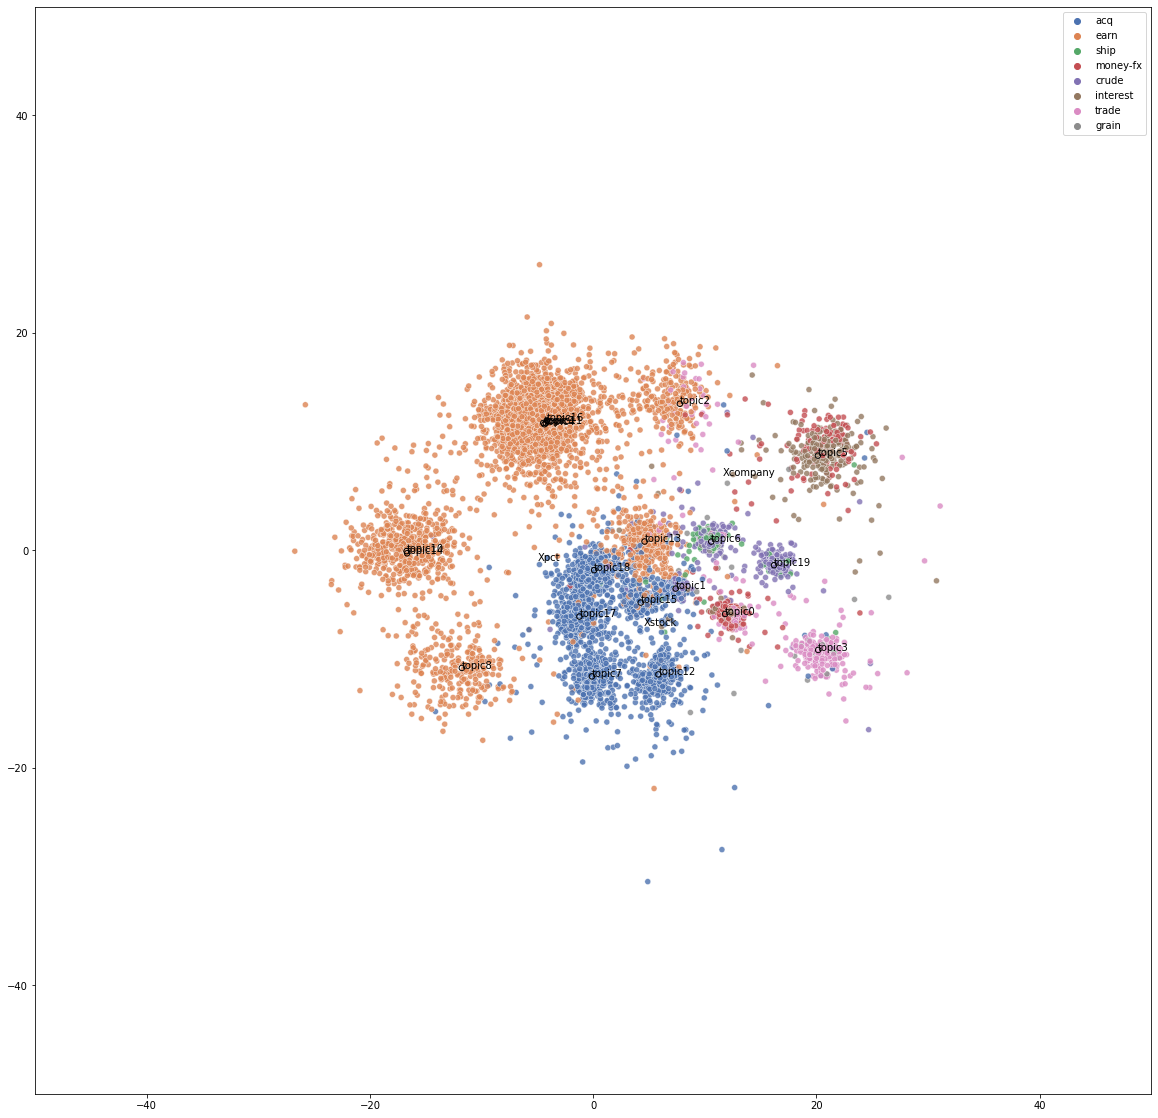

In [ ]:
plot_fig(x_list, labels_list, zphi,query_words)

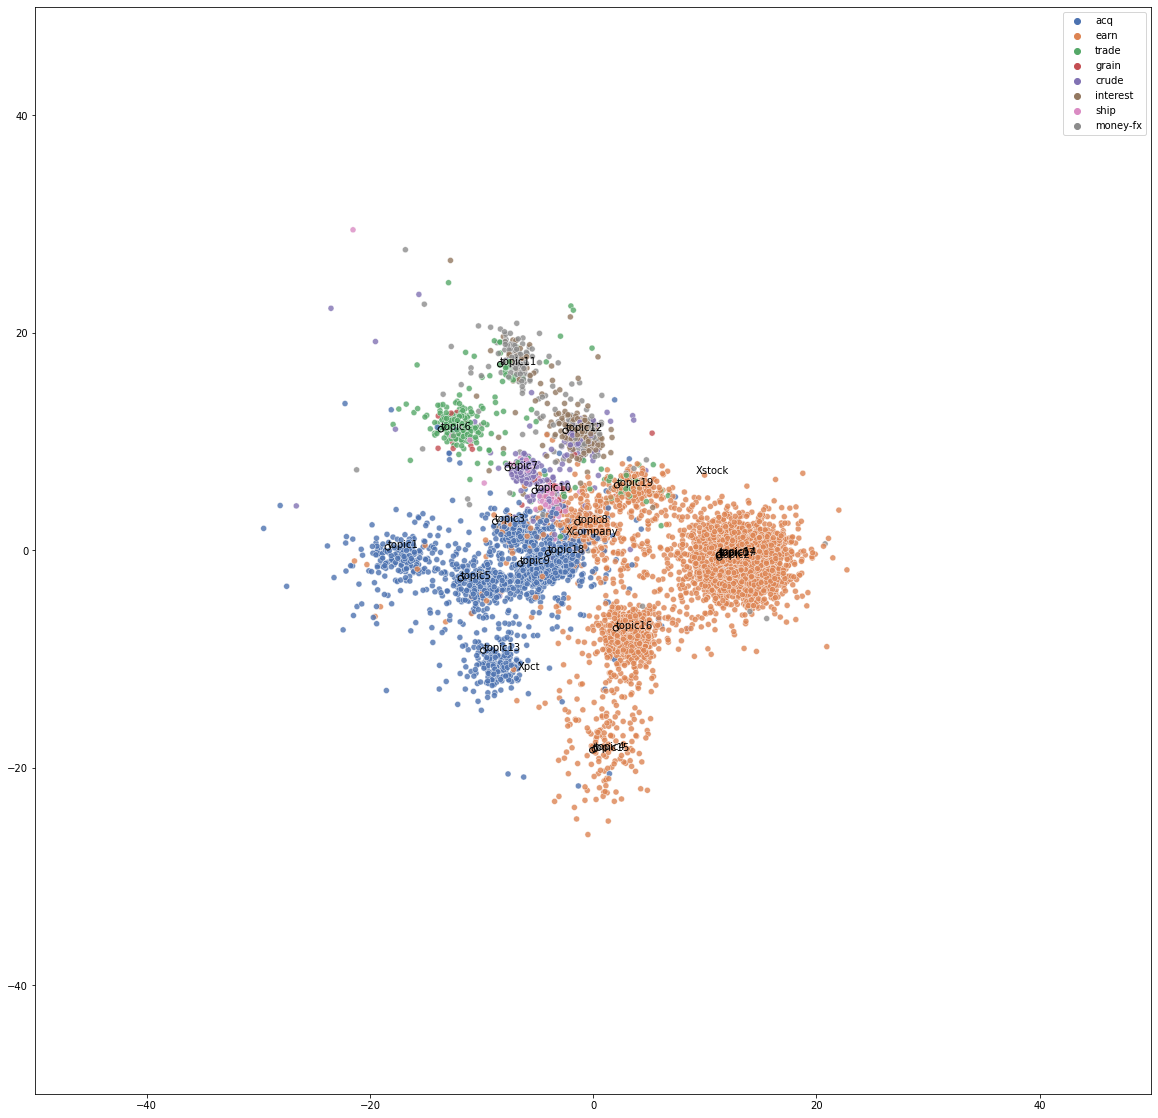

In [ ]:
plot_fig(x_list, labels_list, zphi,query_words)

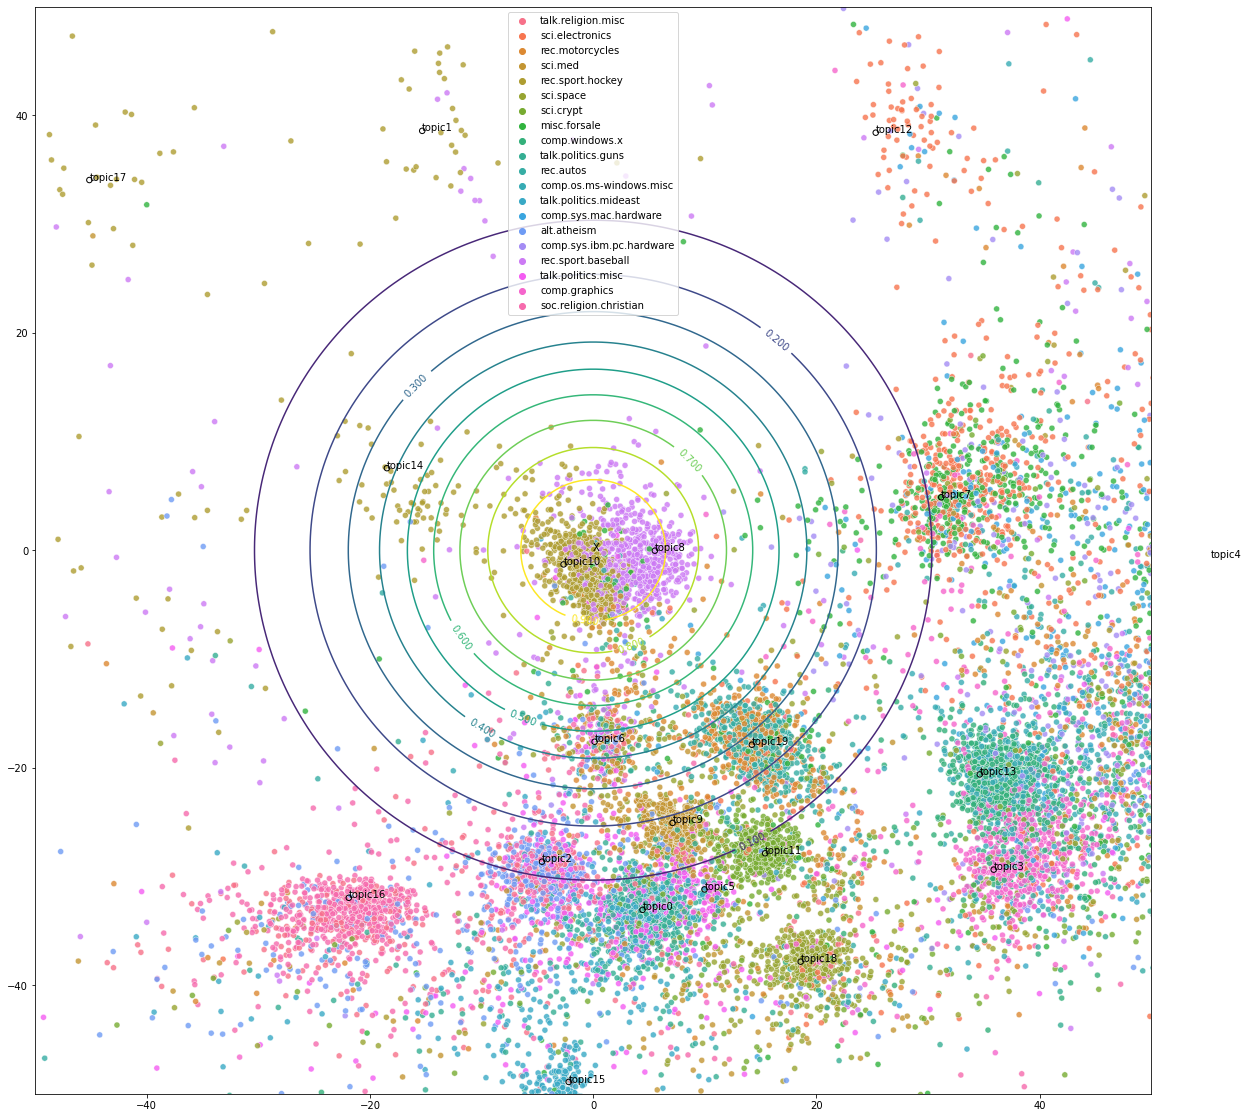

In [ ]:
plot_fig(x_list, labels_list, zphi,query_center)



#WordCloud



In [ ]:
!pip install wordcloud

In [ ]:
word_list=data_20news_preprocessed[j].split()
print(word_list)
flatten_all_words

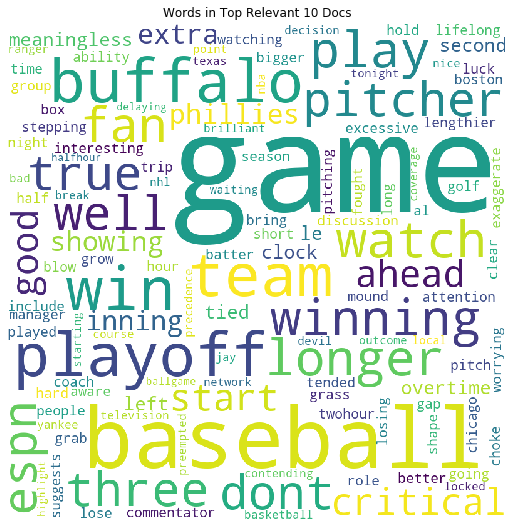

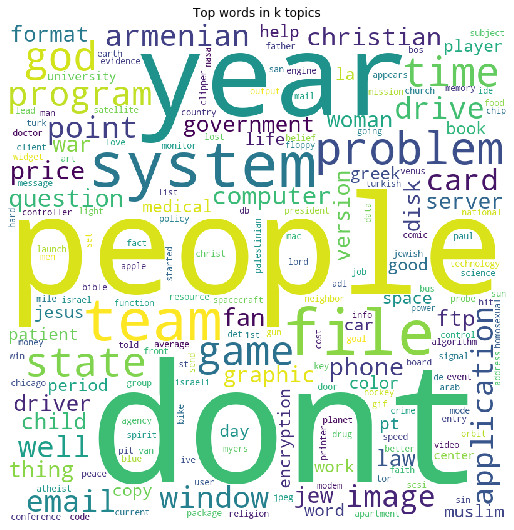

In [ ]:
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
from matplotlib import pyplot as plt

comment_words = ''
topic_topword_comment = ''

for val in top_10_docs:
    comment_words += " ".join(val)+" "

for topword_topic in topword_topics_list:
    topic_topword_comment += " ".join(topword_topic)+" "

wordcloud_top10_docs = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

wordcloud_topword_topics = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(topic_topword_comment)

f = plt.figure(1,figsize = (8, 8))
plt.title('Words in Top Relevant 10 Docs')
plt.axis("off")
plt.tight_layout(pad = 3.0)
plt.imshow(wordcloud_top10_docs)
g = plt.figure(2,figsize = (8, 8))
plt.title("Top Words in k topics")
plt.axis("off")
plt.tight_layout(pad = 3.0)
plt.imshow(wordcloud_topword_topics)
plt.show()

#Archive

In [ ]:
plt.hist(x=all_rscores.data)


from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
normalized_all_rscores = scaler.fit_transform(all_rscores.data.reshape(-1,1))
normalized_all_rscores

In [ ]:
plt.hist(x=normalized_all_rscores)
# print(normalized_all_rscores)
np.max(normalized_all_rscores.flatten())

In [ ]:
all_words_in_docs=[]

def doc_to_words(doc):
  word_list=[]
  for i in doc:
    words = i.split()
    word_list.append([w for w in words])
  return word_list
all_words_in_docs = doc_to_words(data_20news_preprocessed)

In [ ]:
# with open('neg_log_rscore_arr.txt', 'w') as filehandle:
#     for listitem in neg_log_rscore_arr:
#         filehandle.write('%s\n' % listitem)

In [ ]:
# data_20news_preprocessed = []
# data_20news_preprocessed_labels = []
# for i in range(len(data_20news.data)):
#   doc = preprocessing_nonstem(data_20news.data[i],word2vec_model)
#   if(doc!=''):
#     data_20news_preprocessed.append(doc)
#     data_20news_preprocessed_labels.append(targets_20news[i])

In [ ]:
# data_20news_embedded = []
# for word in all_words_in_docs:
#   for w in word:
#     try:
#       type(word2vec_model[w])=='numpy.ndarray'
#     except KeyError:
#       word.remove(w)
#   data_20news_embedded.append(' '.join(word))
# # data_20news_embedded

In [ ]:
# max = 0
# j = 0
# for i,v in enumerate(all_rscores):
#   if(v>max):
#     max,j = v,i
# print(j,max,data_20news_preprocessed[j])

In [ ]:
def flatten_list(user_list):
  return [item for sublist in user_list for item in sublist]
flatten_all_words = flatten_list(all_words_in_docs)
# flatten_embedded = flatten_list(data_20news_embedded)
# flatten_embedded

In [ ]:
# count=0
# embeddings = {}

# for f in flatten_all_words:
#   try :
#      embeddings[f] = word2vec_model[f]
#   except KeyError:
#     count = count+1
#     # print(f)
# print( count / len(flatten_all_words)*100)
# # len(flatten) - count

# keywords = ['illness','disease','fatal','diagnosis']
# for k in keywords:
#   embeddings[k] = word2vec_model[k]
# embeddings

In [ ]:
# def cosine_similarity_desm_np(query_list,doc,embeddings):
#   doc_bar = np.zeros(300)
#   for d in doc:
#     doc_bar = doc_bar + embeddings[d] / np.linalg.norm(embeddings[d])
#   doc_bar = doc_bar / len(doc)
#   sim = []
#   for i in query_list:
#     sim.append(np.dot(word2vec_model[i],doc_bar) / (np.linalg.norm(word2vec_model[i])*np.linalg.norm(doc_bar)) )
#   return doc_bar,sim

In [ ]:
# def cosine_similarity_desm(query_list,doc,embeddings):
#   doc_bar = torch.zeros(300)
#   for d in doc:
#     doc_bar.add_(torch.from_numpy(embeddings[d])) / torch.norm(torch.from_numpy(embeddings[d]),p='fro')
#   doc_bar = doc_bar / len(doc)

#   sim_list = []
#   sim=torch.zeros(1)

#   current=0
#   for q in query_list:
#     sim_list.append(torch.dot(torch.from_numpy(word2vec_model[q]) , doc_bar) / (torch.mul(torch.norm(torch.from_numpy(word2vec_model[q])),torch.norm(doc_bar))))
#     sim.add_(sim_list[current])
#     sim_return = sim / len(sim)
#     current=current+1
#   return sim_return

In [ ]:
import plotly.graph_objects as go
epochs=1000
def plot_loss(y,name):
  figure = go.Figure()
  figure.add_trace(go.Scatter(x=[i for i in range(1,epochs+1)], y=y,mode='lines',name=name))
  figure.show(renderer='colab')

plot_loss(x_arr,'KLD')
plot_loss(recon_arr,'Recon_loss')
plot_loss(neg_log_rscore_arr,'RScore')

> Keyword search in corpus: Returns docs with matching keywords


In [ ]:
matching = [s for s in data_20news_preprocessed if " sport " in s]


  > # Google Pre-trained Model & Word2Vec



In [ ]:
# !wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

In [ ]:
# start=time()
# !gunzip GoogleNews-vectors-negative300.bin.gz
# print('Cell took %.2f seconds to run.' % (time() - start))

In [ ]:
# !zip embeddings.zip /content/embeddings.csv
# !wget -c "https://www.dropbox.com/s/bgtlhwclz0soy4e/embeddings.zip"

In [ ]:
from gensim import models
word2vec_model = models.KeyedVectors.load_word2vec_format(
    'C:/Users/sanuj/Documents/FoTo/GoogleNews-vectors-negative300.bin/GoogleNews-vectors-negative300.bin', binary=True)
# print('Cell took %.2f seconds to run.' % (time() - start))

C:\Users\sanuj\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
## loading original document
from sklearn.datasets import fetch_20newsgroups
data_20news=fetch_20newsgroups(subset='all',remove=('headers', 'footers', 'quotes'))

In [ ]:
data_20news.target_names

In [ ]:
data_20news.target

array([10,  3, 17, ...,  3,  1,  7])

In [ ]:
data_20news_fetch = []
for i in range(len(data_20news.data)):
  doc = preprocessing_nonstem(data_20news.data[i],word2vec_model)
  if(doc!=''):
    data_20news_fetch.append(doc)

In [ ]:
save_obj(data_20news_fetch,'data_20News_preprocessed_new')

In [ ]:
len(data_20news_fetch)

18283

In [ ]:
!dir